# Image Classification & SHAP

This notebook trains 6 different ML algorithms (KNN, MLP, SVM, Naive Bayes, CNN, AlexNet) for both multiclass and binary classification of dementia. Two datasets are used:


1.   kaggle dataset - 6400 MRI scans
2.   OASIS dataset - 235 MRI scans

The kaggle dataset was used to train the algorithms and the OASIS dataset was used to validate results.

SHAP, an approach for explaining the output of any machine learning model, was then implemented to determine which regions of the MRI scans were most influential in classification. 






# Loading Packages

In [ ]:
#@title Run this to load packages 

import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from numpy import expand_dims
import os
from zipfile import ZipFile
import PIL
from PIL import Image
from numpy import asarray
import glob
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
!pip install -q git+https://github.com/rdk2132/scikeras # workaround for scikeras deprecation
from scikeras.wrappers import KerasClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
!pip install shap


def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history_
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 7)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading and preparing data - kaggle dataset
> https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive/')

# downloads kaggle dataset and unzips zip file from drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# !kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset
file_name = 'drive/MyDrive/Extracurriculars/InspiritAI/Deniz Yilmaz/Data/Old MRI Data/alzheimer-mri-dataset.zip' # once dataset is downloaded in google drive, change the filepath to your filepath
with ZipFile(file_name, 'r') as zipfile:
    zipfile.extractall()

# creates label list and image list
label_dirs = glob.glob("/content/Dataset/*")
image_list = []

# puts images in image_list
for label_dir in label_dirs:
  label = label_dir.split("/")[3]
  for file in glob.glob(label_dir + "/*.jpg"):
    image = Image.open(file).resize((150,150)) 
    numpydata = asarray(image)
    image_item = np.array([label, file, numpydata])
    image_list.append(image_item)

# converts image_list to numpy array
image_array = np.asarray(image_list)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# normalization function
def normalize_one_image(image):
  return((image - np.min(image)) / (np.max(image) - np.min(image)))

# label conversion function
def label_to_number(label):
  if label == "Very_Mild_Demented":
    return 1
  if label == "Moderate_Demented":
    return 3
  if label == "Mild_Demented":
    return 2
  if label == "Non_Demented":
    return 0

  return -1

# converts grayscale to black and white
def black_and_white(image):
  for i in range(len(image)):
    if image[i] > 0.5:
      image[i] = 1
    if image[i] <= 0.5:
      image[i] = 0
  return image

# creates normalized_image_array and label_array
normalized_image_array = []
label_array = []

# adds normalized images to normalized_image_array and new labels to label_array
for item in image_array:
  img = item[2]
  img = normalize_one_image(img)
  img = img.flatten()
  # img = black_and_white(img)
  label = label_to_number(item[0])
  normalized_image_array.append(img)
  label_array.append(label)

In [ ]:
# converts to binary labels
label_binary = label_array.copy()

for idx in range(len(label_binary)):
  if label_binary[idx] == 3 or label_binary[idx] == 2:
    label_binary[idx] = 1

# Train test validation split

In [ ]:
# sets ratios for train, validation, and test
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# multiclass
X = asarray(normalized_image_array)
y = asarray(label_array)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=9)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=9)

# binary
y_binary = asarray(label_binary)

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=1 - train_ratio, random_state=9)
X_val_binary, X_test_binary, y_val_binary, y_test_binary = train_test_split(X_test_binary, y_test_binary, test_size=test_ratio/(test_ratio + validation_ratio), random_state=9) 


# Training ML models
> KNN, MLP, SVM, Naive Bayes, CNN, AlexNet

## KNN multiclass

In [ ]:
# initialize model
knn_multiclass = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='euclidean')

# train
knn_multiclass.fit(X_train, y_train)

# predict
predictions_knn_multiclass = knn_multiclass.predict(X_val)

# model metrics
print("accuracy score: ", accuracy_score(y_val, predictions_knn_multiclass))
print("precision score: ", precision_score(y_val, predictions_knn_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_val, predictions_knn_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_val, predictions_knn_multiclass, average = 'weighted'))

Confusion Matrix

[[461   1   0   0]
 [  5 334   0   0]
 [  0   0 147   0]
 [  0   0   0  13]]


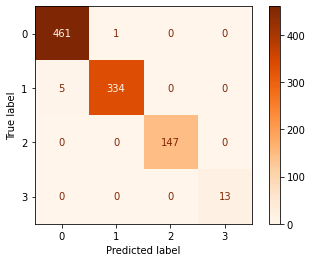

In [ ]:
# confusion matrix for KNN multiclass

confusion = confusion_matrix(y_val, predictions_knn_multiclass)
print('Confusion Matrix\n')
print(confusion)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["0", "1", "2", "3"])
disp.plot(cmap='Oranges');

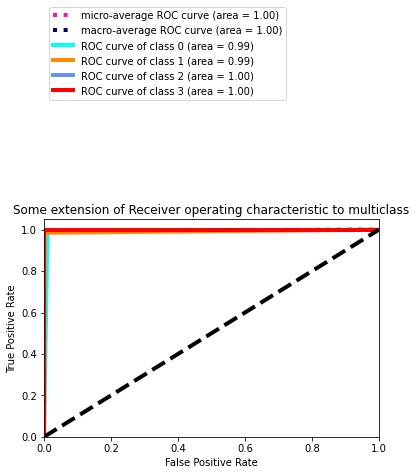

In [ ]:
# ROC curve for KNN multiclass

# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 4
y_score = label_binarize(predictions_knn_multiclass, classes=[0, 1, 2, 3])
y_test_bin = label_binarize(y_val, classes=[0, 1, 2, 3])

lw = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# first aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue", "red"]
for i, color in enumerate(colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(bbox_to_anchor=(0, 2), loc='upper left', ncol=1)
plt.show()

In [ ]:
# KNN multiclass hyperparameter tuning

for i in range(10):
  # initialize model
  knn_multiclass = KNeighborsClassifier(n_neighbors=(i+1), weights='distance', metric='euclidean')

  # train
  knn_multiclass.fit(X_train, y_train)

  # predict
  predictions_knn_multiclass = knn_multiclass.predict(X_val)

  # model metrics
  print("KNN Testing Accuracy: neighbors = ", i+1)
  print(accuracy_score(y_val, predictions_knn_multiclass))
  print("precision: ")
  print(precision_score(y_val, predictions_knn_multiclass, average = 'weighted'))
  print("recall: ")
  print(recall_score(y_val, predictions_knn_multiclass, average = 'weighted'))
  print("")

KNN Testing Accuracy: neighbors =  1
0.9947916666666666
precision: 
0.9947919078676546
recall: 
0.9947916666666666



KeyboardInterrupt: ignored

## MLP multiclass

In [ ]:
# initialize model
mlp_multiclass = MLPClassifier(hidden_layer_sizes=(10, 5, 4), random_state=1, max_iter= 100)  

# train
mlp_multiclass.fit(X_train, y_train)

# predict
predictions_mlp_multiclass = mlp_multiclass.predict(X_val)

# model metrics
print("accuracy score: ", accuracy_score(y_val, predictions_mlp_multiclass))
print("precision score: ", precision_score(y_val, predictions_mlp_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_val, predictions_mlp_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_val, predictions_mlp_multiclass, average = 'weighted'))

accuracy score:  0.48074921956295524
precision score:  0.23111981211039057
recall score:  0.48074921956295524
f1 score:  0.3121660427801621


## SVC multiclass

In [ ]:
# experimenting with different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel_type in kernels:
  # initialize model
  svc_multiclass = svm.SVC(kernel = kernel_type)

  #train
  svc_multiclass.fit(X_train, y_train)
  
  #predict
  predictions_svc_multiclass = svc_multiclass.predict(X_val)

  # Print the score on the validation data
  print("SVC model metrics ", kernel_type)
  print("accuracy score: ", accuracy_score(y_val, predictions_svc_multiclass))
  print("precision score: ", precision_score(y_val, predictions_svc_multiclass, average = 'weighted'))
  print("recall score: ", recall_score(y_val, predictions_svc_multiclass, average = 'weighted'))
  print("f1 score: ", f1_score(y_val, predictions_svc_multiclass, average = 'weighted'))
  print("")

SVC Testing Accuracy  linear
97.60416666666667
SVC Testing Accuracy  poly
89.6875
SVC Testing Accuracy  rbf
73.54166666666667
SVC Testing Accuracy  sigmoid
31.458333333333332

all model metrics for linear kernel:
accuracy score:  0.9791883454734651
precision score:  0.9793121912640933
recall score:  0.9791883454734651
f1 score:  0.9791000162386984


## Naive Bayes multiclass

In [ ]:
# initialize model 
nb_multiclass = GaussianNB(var_smoothing = 1e-4)

# train
nb_multiclass.fit(X_train, y_val)

# predict
predictions_nb_multiclass = nb_multiclass.predict(X_val)

print("accuracy score: ", accuracy_score(y_val, predictions_nb_multiclass))
print("precision score: ", precision_score(y_val, predictions_nb_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_val, predictions_nb_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_val, predictions_nb_multiclass, average = 'weighted'))

## CNN Multiclass

In [ ]:
def CNNClassifier(num_classes=4, num_epochs=2, layers=2, dropout=0.25):
  def create_model():
    model = Sequential()
    model.add(Reshape((150, 150, 1)))

    for i in range(layers):
      model.add(Conv2D(150, (3, 3), padding='same'))
      model.add(Activation('relu'))
    
    model.add(Conv2D(150, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    # model.add(Conv2D(64, (3, 3), padding='same'))
    # model.add(Activation('relu'))
    # model.add(Conv2D(64, (3, 3)))
    # model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

  opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)
  return KerasClassifier(model=create_model, optimizer=opt, 
                         loss='categorical_crossentropy', epochs=num_epochs, batch_size=10, 
                         metrics=['accuracy'])

cnn_multiclass = CNNClassifier(4, 100, 1, 0.25)
history = cnn_multiclass.fit(X=X_train, y=y_train, validation_data=(X_val, y_val))
plot_acc(history)

predictions_cnn_multiclass = cnn_multiclass.predict(X_val)
print("accuracy score: ", accuracy_score(y_val, predictions_cnn_multiclass))
print("precision score: ", precision_score(y_val, predictions_cnn_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_val, predictions_cnn_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_val, predictions_cnn_multiclass, average = 'weighted'))

Epoch 1/100


RuntimeError: ignored

## AlexNet multiclass

In [ ]:
def AlexNetClassifier(num_classes=4, num_epochs=2):
  def create_model():
    model = Sequential()
    model.add(Reshape((150, 150, 1)))

    model.add(Conv2D(96, 11, strides = 3))
    model.add(Activation('relu'))

    model.add(Conv2D(256, 5))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(2))
    model.add(Activation('relu'))

    model.add(Conv2D(384, 3, padding = 'same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(2))
    model.add(Activation('relu'))

    model.add(Conv2D(384, 3, padding = 'same'))
    model.add(Activation('relu'))

    model.add(Conv2D(256, 3, padding = 'same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(2))
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(4096))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dense(4))
    model.add(Activation('softmax'))

    return model

  opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)
  return KerasClassifier(model=create_model, optimizer=opt, 
                         loss='categorical_crossentropy', epochs=num_epochs, batch_size=64, 
                         metrics=['accuracy'])

AlexNet_multiclass = AlexNetClassifier(4, 100)
history = AlexNet_multiclass.fit(X=X_train, y=y_train, validation_data=(X_val, y_val))
plot_acc(history)

predictions_AlexNet_multiclass = AlexNet_multiclass.predict(X_val)
print("accuracy score: ", accuracy_score(y_val, predictions_AlexNet_multiclass))
print("precision score: ", precision_score(y_val, predictions_AlexNet_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_val, predictions_AlexNet_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_val, predictions_AlexNet_multiclass, average = 'weighted'))



Epoch 1/100
47/70 [===================>..........] - ETA: 1s - loss: 1.0771 - accuracy: 0.4678

KeyboardInterrupt: ignored

## KNN binary

In [ ]:
# initialize model
knn_binary = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='euclidean')

# train
knn_binary.fit(X_train_binary, y_train_binary)

# predict
predictions_knn_binary = knn_binary.predict(X_val_binary)

# model metrics
print("accuracy score: ", accuracy_score(y_val_binary, predictions_knn_binary))
print("precision score: ", precision_score(y_val_binary, predictions_knn_binary, average='weighted'))
print("recall score: ", recall_score(y_val_binary, predictions_knn_binary, average='weighted'))
print("f1 score: ", f1_score(y_val_binary, predictions_knn_binary,average='weighted'))


accuracy score:  0.9989594172736732
precision score:  0.9989615110014928
recall score:  0.9989594172736732
f1 score:  0.9989593811774613


Confusion Matrix

[[496   5]
 [  1 459]]


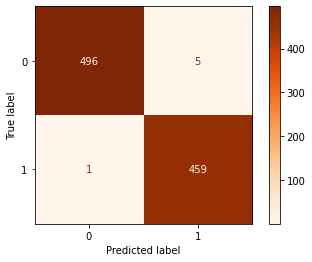

In [ ]:
# confusion matrix for KNN binary

confusion = confusion_matrix(y_val_binary, predictions_knn_binary)
print('Confusion Matrix\n')
print(confusion)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["0", "1"])
disp.plot(cmap='Oranges');

In [ ]:
# ROC curve for KNN binary

# Compute ROC curve and ROC area for each class
y_score = predictions_knn_binary

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

ValueError: ignored

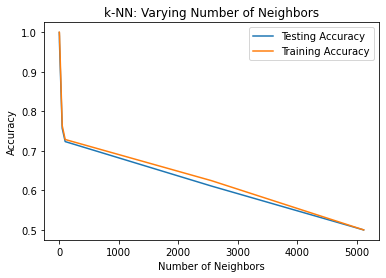

In [ ]:
# KNN binary plots 

neighbors = np.arange(1, 5)
neighbors = np.append(neighbors, [50, 100, 2560, 5120])

# arrays to store train and test accuracies

train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# iterate through different values of k
for i, k in enumerate(neighbors):
    # initialize model
    knn_binary = KNeighborsClassifier(n_neighbors=k)

    # train
    knn_binary.fit(X_train_binary, y_train_binary)
    
    # test on training set
    train_accuracy[i] = knn_binary.score(X_train_binary, y_train_binary)

    # test on testing set
    test_accuracy[i] = knn_binary.score(X_val_binary, y_val_binary)

# Generate plot
plt.title('KNN: varying number of neighbors')
plt.plot(neighbors, test_accuracy, label = 'testing accuracy')
plt.plot(neighbors, train_accuracy, label = 'training accuracy')
plt.legend()
plt.xlabel('number of neighbors')
plt.ylabel('accuracy')
plt.show()


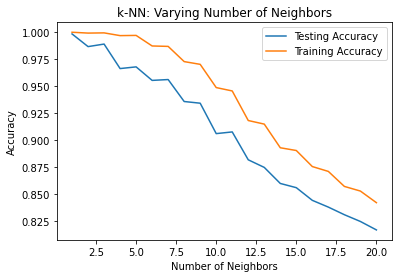

In [ ]:
# more KNN binary plots

neighbors = np.arange(1,21)

train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# iterate through different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn_binary = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn_binary.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn_binary.score(X_train, y_train)

    #Compute accuracy on the testing set
    val_accuracy[i] = knn_binary.score(X_val, y_val)

# Generate plot
plt.title('KNN: varying number of neighbors')
plt.plot(neighbors, val_accuracy, label = 'Validation Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

## MLP binary

In [ ]:
# initialize model
mlp_binary = MLPClassifier(hidden_layer_sizes=(10, 5, 4), random_state=1, max_iter= 100)  

# train
mlp_binary.fit(X_train_binary, y_train_binary)

# predict
predictions_mlp_binary = mlp_binary.predict(X_val_binary)

# model metrics
print("accuracy score: ", accuracy_score(y_val_binary, predictions_mlp_binary))
print("precision score: ", precision_score(y_val_binary, predictions_mlp_binary, average='weighted'))
print("recall score: ", recall_score(y_val_binary, predictions_mlp_binary, average='weighted'))
print("f1 score: ", f1_score(y_val_binary, predictions_mlp_binary, average='weighted'))

accuracy score:  0.5161290322580645
precision score:  0.2663891779396462
recall score:  0.5161290322580645
f1 score:  0.3514070006863418


## SVC binary

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel_type in kernels:
  # initialize model
  svc_binary = svm.SVC(kernel = kernel_type)

  # train
  svc_binary.fit(X_train, y_train_binary)

  # predict 
  predictions_svc_binary = svc_binary.predict(X_val)
  
  # Print the score on the validation data
  print("SVC model metrics ", kernel_type)
  print("accuracy score: ", accuracy_score(y_val_binary, predictions_svc_binary))
  print("precision score: ", precision_score(y_val_binary, predictions_svc_binary))
  print("recall score: ", recall_score(y_val_binary, predictions_svc_binary))
  print("f1 score: ", f1_score(y_val_binary, predictions_svc_binary))
  print("")

SVC Testing Accuracy  linear
97.81477627471385
SVC Testing Accuracy  poly
91.67533818938605
SVC Testing Accuracy  rbf
80.64516129032258
SVC Testing Accuracy  sigmoid
35.90010405827263

accuracy score:  0.9781477627471384
precision score:  0.9837067209775967
recall score:  0.9737903225806451
f1 score:  0.978723404255319


## Naive Bayes binary

In [ ]:
# initialize model
nb_binary = GaussianNB(var_smoothing = 10)

# train
nb_binary.fit(X_train_binary, y_train_binary)

# predict
predictions_nb_binary = nb_binary.predict(X_val_binary)
print("accuracy score: ", accuracy_score(y_val_binary, predictions_nb_binary))
print("precision score: ", precision_score(y_val_binary, predictions_nb_binary, average = 'weighted'))
print("recall score: ", recall_score(y_val_binary, predictions_nb_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_val_binary, predictions_nb_binary, average = 'weighted'))

accuracy score:  0.6077003121748179
precision score:  0.6239829473912961
recall score:  0.6077003121748179
f1 score:  0.5996413557676445


## CNN binary

In [ ]:
def CNNClassifier(num_classes=2, num_epochs=2, layers=2, dropout=0.25):
  def create_model():
    model = Sequential()
    model.add(Reshape((150, 150, 1)))

    for i in range(layers):
      model.add(Conv2D(150, (3, 3), padding='same'))
      model.add(Activation('relu'))
    
    model.add(Conv2D(150, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    # model.add(Conv2D(64, (3, 3), padding='same'))
    # model.add(Activation('relu'))
    # model.add(Conv2D(64, (3, 3)))
    # model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

  opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)
  return KerasClassifier(model=create_model, optimizer=opt, 
                         loss='sparse_categorical_crossentropy', epochs=num_epochs, batch_size=10, 
                         metrics=['accuracy'])

cnn_binary = CNNClassifier(2, 70, 1, 0.25)
history = cnn_binary.fit(X=X_train, y=y_train, validation_data=(X_val, y_val))
plot_acc(history)

predictions_cnn_binary = predictions_cnn_binary.predict(X_val)
print("accuracy score: ", accuracy_score(y_val, predictions_cnn_binary))
print("precision score: ", precision_score(y_val, predictions_cnn_binary, average = 'weighted'))
print("recall score: ", recall_score(y_val, predictions_cnn_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_val, predictions_cnn_binary, average = 'weighted'))

Epoch 1/70


ResourceExhaustedError: ignored

In [ ]:
# hyperparameter tuning CNN binary

from keras.wrappers.scikit_learn import KerasClassifier as KerasClassifier2
def create_model(num_classes=2, num_epochs=2, layers=1, dropout=0.15, learning_rate=0.0001, decay=1e-6):
    print("Dropout: ", dropout)
    print("Num Epochs: ", num_epochs)
    print("Learning rate: ", learning_rate)    
    print("Decay ", decay)    
    print("Layers ", layers)    
    
    model = Sequential()
    model.add(Reshape((32, 32, 1)))

    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    # model.add(Conv2D(64, (3, 3), padding='same'))
    # model.add(Activation('relu'))
    # model.add(Conv2D(64, (3, 3)))
    # model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate, decay=decay), 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy'])

    return model

CNNClassifier = KerasClassifier2(build_fn=create_model)

## AlexNet binary

In [ ]:
def AlexNetClassifier(num_classes=2, num_epochs=2):
  def create_model():
    model = Sequential()
    model.add(Reshape((150, 150, 1)))

    model.add(Conv2D(96, 11, strides = 3))
    model.add(Activation('relu'))

    model.add(Conv2D(256, 5))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(2))
    model.add(Activation('relu'))

    model.add(Conv2D(384, 3, padding = 'same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(2))
    model.add(Activation('relu'))

    model.add(Conv2D(384, 3, padding = 'same'))
    model.add(Activation('relu'))

    model.add(Conv2D(256, 3, padding = 'same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(2))
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(4096))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dense(2))
    model.add(Activation('softmax'))

    return model

  opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)
  return KerasClassifier(model=create_model, optimizer=opt, 
                         loss='sparse_categorical_crossentropy', epochs=num_epochs, batch_size=64, verbose=2, 
                         metrics=['accuracy'])

AlexNet_binary = AlexNetClassifier(2, 70)
history = AlexNet_binary.fit(X=X_train, y=y_train, validation_data=(X_val, y_val))
plot_acc(history)

predictions_AlexNet_binary = AlexNet_binary.predict(X_val)
print("accuracy score: ", accuracy_score(y_val_binary, predictions_AlexNet_binary))
print("precision score: ", precision_score(y_val_binary, predictions_AlexNet_binary, average = 'weighted'))
print("recall score: ", recall_score(y_val_binary, predictions_AlexNet_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_val_binary, predictions_AlexNet_binary, average = 'weighted'))



Epoch 1/70
70/70 - 7s - loss: 0.6931 - accuracy: 0.5122 - 7s/epoch - 96ms/step
Epoch 2/70
70/70 - 6s - loss: 0.6529 - accuracy: 0.6213 - 6s/epoch - 81ms/step
Epoch 3/70
70/70 - 6s - loss: 0.6063 - accuracy: 0.6767 - 6s/epoch - 82ms/step
Epoch 4/70
70/70 - 6s - loss: 0.5747 - accuracy: 0.7077 - 6s/epoch - 82ms/step
Epoch 5/70
70/70 - 6s - loss: 0.5466 - accuracy: 0.7287 - 6s/epoch - 82ms/step
Epoch 6/70
70/70 - 6s - loss: 0.5247 - accuracy: 0.7381 - 6s/epoch - 83ms/step
Epoch 7/70
70/70 - 6s - loss: 0.5024 - accuracy: 0.7564 - 6s/epoch - 83ms/step
Epoch 8/70
70/70 - 6s - loss: 0.4483 - accuracy: 0.7877 - 6s/epoch - 83ms/step
Epoch 9/70
70/70 - 6s - loss: 0.3868 - accuracy: 0.8230 - 6s/epoch - 82ms/step
Epoch 10/70
70/70 - 6s - loss: 0.3156 - accuracy: 0.8614 - 6s/epoch - 82ms/step
Epoch 11/70
70/70 - 6s - loss: 0.2544 - accuracy: 0.9002 - 6s/epoch - 82ms/step
Epoch 12/70
70/70 - 6s - loss: 0.2054 - accuracy: 0.9290 - 6s/epoch - 81ms/step
Epoch 13/70
70/70 - 6s - loss: 0.1574 - accuracy:

# Loading and preparing data - oasis dataset
> https://www.oasis-brains.org/#data

In [ ]:
def label_converter(label):
  if label == 0.5:
    label = 1
  elif label == 1:
    label = 2
  elif label == 2:
    label =3

  # 0: non-demented
  # 1: very mild demented
  # 2: mild demented
  # 3: moderate demented
  
  return label

oasis_dataset_dir = 'drive/MyDrive/Extracurriculars/InspiritAI/Deniz Yilmaz/Data/oasis_dataset'

# creates label list and image list
subject_dirs = glob.glob(oasis_dataset_dir + "/OAS1*")
oasis_normalized_image_array = []
oasis_label_array = []

oasis_df = pd.read_csv(oasis_dataset_dir + "/oasis_cross-sectional_filtered.csv")

# puts stuff in image_list
for subject_dir in subject_dirs:
  # print(subject_dir)
  subject_id = subject_dir.split("/")[7]
  # print(subject_id)
  label = oasis_df.loc[oasis_df['ID'] == subject_id]['CDR'].item()
  # print(label)
  label = label_converter(label)
  for file in glob.glob(subject_dir + "/PROCESSED/MPRAGE/T88_111/*masked_gfc_tra_90.gif"):
    image = Image.open(file).resize((32,32))
    image = image.rotate(180)
    image = image.convert('L') # convert RGB to gray
    image = asarray(image)
    image = normalize_one_image(image)
    image = image.flatten()
    # image = black_and_white(image)
    oasis_normalized_image_array.append(image)
    oasis_label_array.append(label) 

# creating binary labels
oasis_label_binary = oasis_label_array.copy()

for idx in range(len(oasis_label_binary)):
  if oasis_label_binary[idx] == 3 or oasis_label_binary[idx] == 2:
    oasis_label_binary[idx] = 1

# multiclass array
X_oasis = asarray(oasis_normalized_image_array)
y_oasis = asarray(oasis_label_array)

# binary array
y_oasis_binary = asarray(oasis_label_binary)

# Testing

## Testing oasis dataset

In [ ]:
# knn multiclass
predictions_knn_multiclass_oasis = knn_multiclass.predict(X_oasis)

# knn binary
predictions_knn_binary_oasis = knn_binary.predict(X_oasis)

# mlp multiclass
predictions_mlp_multiclass_oasis = mlp_multiclass.predict(X_oasis)

# mlp binary
predictions_mlp_binary_oasis = mlp_binary.predict(X_oasis)

# svm multiclass
predictions_oasis_svc_multiclass = svc_multiclass.predict(X_oasis)

# svm binary
predictions_oasis_svc_binary = svc_binary.predict(X_oasis)

# naive bayes multiclass
predictions_oasis_nb_multiclass = nb_multiclass.predict(X_oasis)

# naive bayes binary
predictions_oasis_nb_binary = nb_binary.predict(X_oasis)

# cnn multiclass
predictions_oasis_cnn_multiclass = cnn_multiclass.predict(X_oasis)

# cnn binary
predictions_oasis_cnn_binary = cnn_binary.predict(X_oasis)

# alexnet multiclass
predictions_oasis_AlexNet_multiclass = AlexNet_multiclass.predict(X_oasis)

# alexnet multiclass
predictions_oasis_AlexNet_multiclass = AlexNet_multiclass.predict(X_oasis)

# Print the metrics on the oasis data
print("knn multiclass: ")
print("accuracy score: ", accuracy_score(y_oasis, predictions_knn_multiclass_oasis))
print("precision score: ", precision_score(y_oasis, predictions_knn_multiclass_oasis, average = 'weighted'))
print("recall score: ", recall_score(y_oasis, predictions_knn_multiclass_oasis, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis, predictions_knn_multiclass_oasis, average = 'weighted'))
print("")
print("knn binary: ")
print("accuracy score: ", accuracy_score(y_oasis_binary, predictions_knn_binary_oasis))
print("precision score: ", precision_score(y_oasis_binary, predictions_knn_binary_oasis, average = 'weighted'))
print("recall score: ", recall_score(y_oasis_binary, predictions_knn_binary_oasis, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis_binary, predictions_knn_binary_oasis, average = 'weighted'))
print("")
print("mlp multiclass: ")
print("accuracy score: ", accuracy_score(y_oasis, predictions_mlp_multiclass_oasis))
print("precision score: ", precision_score(y_oasis, predictions_mlp_multiclass_oasis, average = 'weighted'))
print("recall score: ", recall_score(y_oasis, predictions_mlp_multiclass_oasis, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis, predictions_mlp_multiclass_oasis, average = 'weighted'))
print("")
print("mlp binary:")
print("accuracy score: ", accuracy_score(y_oasis_binary, predictions_mlp_binary_oasis))
print("precision score: ", precision_score(y_oasis_binary, predictions_mlp_binary_oasis, average = 'weighted'))
print("recall score: ", recall_score(y_oasis_binary, predictions_mlp_binary_oasis, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis_binary, predictions_mlp_binary_oasis, average = 'weighted'))
print("")
print("svm multiclass")
print("accuracy score: ", accuracy_score(y_oasis, predictions_oasis_svc_multiclass))
print("precision score: ", precision_score(y_oasis, predictions_oasis_svc_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_oasis, predictions_oasis_svc_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis, predictions_oasis_svc_multiclass, average = 'weighted'))
print("")
print("svm binary")
print("accuracy score: ", accuracy_score(y_oasis_binary, predictions_oasis_svc_binary))
print("precision score: ", precision_score(y_oasis_binary, predictions_oasis_svc_binary, average = 'weighted'))
print("recall score: ", recall_score(y_oasis_binary, predictions_oasis_svc_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis_binary, predictions_oasis_svc_binary, average = 'weighted'))
print("")
print("naive bayes mutliclass")
print("accuracy score: ", accuracy_score(y_oasis, predictions_oasis_nb_multiclass))
print("precision score: ", precision_score(y_oasis, predictions_oasis_nb_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_oasis, predictions_oasis_nb_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis, predictions_oasis_nb_multiclass, average = 'weighted'))
print("")
print("naive bayes binary")
print("accuracy score: ", accuracy_score(y_oasis_binary, predictions_oasis_nb_binary))
print("precision score: ", precision_score(y_oasis_binary, predictions_oasis_nb_binary, average = 'weighted'))
print("recall score: ", recall_score(y_oasis_binary, predictions_oasis_nb_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis_binary, predictions_oasis_nb_binary, average = 'weighted'))
print("")
print("cnn multiclass")
print("accuracy score: ", accuracy_score(y_oasis, predictions_oasis_cnn_multiclass))
print("precision score: ", precision_score(y_oasis, predictions_oasis_cnn_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_oasis, predictions_oasis_cnn_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis, predictions_oasis_cnn_multiclass, average = 'weighted'))
print("")
print("cnn binary")
print("accuracy score: ", accuracy_score(y_oasis_binary, predictions_oasis_cnn_binary))
print("precision score: ", precision_score(y_oasis_binary, predictions_oasis_cnn_binary, average = 'weighted'))
print("recall score: ", recall_score(y_oasis_binary, predictions_oasis_cnn_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis_binary, predictions_oasis_cnn_binary, average = 'weighted'))
print("")
print("alexnet multiclass")
print("accuracy score: ", accuracy_score(y_oasis, predictions_oasis_AlexNet_multiclass))
print("precision score: ", precision_score(y_oasis, predictions_oasis_AlexNet_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_oasis, predictions_oasis_AlexNet_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_oasis, predictions_oasis_AlexNet_multiclass, average = 'weighted'))
print("")
print("alexnet binary")
print("accuracy score: ", accuracy_score(y_oasis_binary, predictions_oasis_AlexNet_binary))
print("precision score: ", precision_score(y_oasis_binary, predictions_oasis_AlexNet_binary, average = 'weighted'))
print("recall score: ", recall_score(y_oasis_binary, predictions_oasis_AlexNet_binary, average = 'weighted'))
3print("f1 score: ", f1_score(y_oasis_binary, predictions_oasis_AlexNet_binary, average = 'weighted'))

knn multiclass: 
accuracy score:  0.6808510638297872
precision score:  0.7016583576605884
recall score:  0.6808510638297872
f1 score:  0.6866942000068543

knn binary: 
accuracy score:  0.7574468085106383
precision score:  0.758553829975024
recall score:  0.7574468085106383
f1 score:  0.7578764150932286

mlp multiclass: 
accuracy score:  0.5829787234042553
precision score:  0.42489292622271346
recall score:  0.5829787234042553
f1 score:  0.4509154445739523

mlp binary:
accuracy score:  0.6382978723404256
precision score:  0.6551070510037076
recall score:  0.6382978723404256
f1 score:  0.5922606261587118


## Testing kaggle dataset

In [ ]:
# knn multiclass
predictions_knn_multiclass = knn_multiclass.predict(X_test)

# knn binary
predictions_knn_binary = knn_binary.predict(X_test)

# mlp multiclass
predictions_mlp_multiclass = mlp_multiclass.predict(X_test)

# mlp binary
predictions_mlp_binary = mlp_binary.predict(X_test)

# svm multiclass
predictions_svc_multiclass = svc_multiclass.predict(X_test)

# svm binary
predictions_svc_binary = svc_binary.predict(X_test)

# naive bayes multiclass
predictions_nb_multiclass = nb_multiclass.predict(X_test)

# naive bayes binary
predictions_nb_binary = nb_binary.predict(X_test)

# cnn multiclass
predictions_cnn_multiclass = cnn_multiclass.predict(X_test)

# cnn binary
predictions_cnn_binary = cnn_binary.predict(X_test)

# alexnet multiclass
predictions_AlexNet_multiclass = AlexNet_multiclass.predict(X_test)

# alexnet multiclass
predictions_AlexNet_multiclass = AlexNet_multiclass.predict(X_test)

# Print the metrics on the kaggle data
print("knn multiclass: ")
print("accuracy score: ", accuracy_score(y_test, predictions_knn_multiclass))
print("precision score: ", precision_score(y_test, predictions_knn_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_test, predictions_knn_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_test, predictions_knn_multiclass, average = 'weighted'))
print("")
print("knn binary: ")
print("accuracy score: ", accuracy_score(y_test_binary, predictions_knn_binary))
print("precision score: ", precision_score(y_test_binary, predictions_knn_binary, average = 'weighted'))
print("recall score: ", recall_score(y_test_binary, predictions_knn_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_test_binary, predictions_knn_binary, average = 'weighted'))
print("")
print("mlp multiclass: ")
print("accuracy score: ", accuracy_score(y_test, predictions_mlp_multiclass))
print("precision score: ", precision_score(y_test, predictions_mlp_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_test, predictions_mlp_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_test, predictions_mlp_multiclass, average = 'weighted'))
print("")
print("mlp binary:")
print("accuracy score: ", accuracy_score(y_test_binary, predictions_mlp_binary))
print("precision score: ", precision_score(y_test_binary, predictions_mlp_binary, average = 'weighted'))
print("recall score: ", recall_score(y_test_binary, predictions_mlp_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_test_binary, predictions_mlp_binary, average = 'weighted'))
print("")
print("svm multiclass")
print("accuracy score: ", accuracy_score(y_test, predictions_svc_multiclass))
print("precision score: ", precision_score(y_test, predictions_svc_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_test, predictions_svc_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_test, predictions_svc_multiclass, average = 'weighted'))
print("")
print("svm binary")
print("accuracy score: ", accuracy_score(y_test_binary, predictions_svc_binary))
print("precision score: ", precision_score(y_test_binary, predictions_svc_binary, average = 'weighted'))
print("recall score: ", recall_score(y_test_binary, predictions_svc_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_test_binary, predictions_svc_binary, average = 'weighted'))
print("")
print("naive bayes mutliclass")
print("accuracy score: ", accuracy_score(y_test, predictions_nb_multiclass))
print("precision score: ", precision_score(y_test, predictions_nb_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_test, predictions_nb_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_test, predictions_nb_multiclass, average = 'weighted'))
print("")
print("naive bayes binary")
print("accuracy score: ", accuracy_score(y_test_binary, predictions_nb_binary))
print("precision score: ", precision_score(y_test_binary, predictions_nb_binary, average = 'weighted'))
print("recall score: ", recall_score(y_test_binary, predictions_nb_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_test_binary, predictions_nb_binary, average = 'weighted'))
print("")
print("cnn multiclass")
print("accuracy score: ", accuracy_score(y_test, predictions_cnn_multiclass))
print("precision score: ", precision_score(y_test, predictions_cnn_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_test, predictions_cnn_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_test, predictions_cnn_multiclass, average = 'weighted'))
print("")
print("cnn binary")
print("accuracy score: ", accuracy_score(y_test_binary, predictions_cnn_binary))
print("precision score: ", precision_score(y_test_binary, predictions_cnn_binary, average = 'weighted'))
print("recall score: ", recall_score(y_test_binary, predictions_cnn_binary, average = 'weighted'))
print("f1 score: ", f1_score(y_test_binary, predictions_cnn_binary, average = 'weighted'))
print("")
print("alexnet multiclass")
print("accuracy score: ", accuracy_score(y_test, predictions_AlexNet_multiclass))
print("precision score: ", precision_score(y_test, predictions_AlexNet_multiclass, average = 'weighted'))
print("recall score: ", recall_score(y_test, predictions_AlexNet_multiclass, average = 'weighted'))
print("f1 score: ", f1_score(y_test, predictions_AlexNet_multiclass, average = 'weighted'))
print("")
print("alexnet binary")
print("accuracy score: ", accuracy_score(y_test_binary, predictions_AlexNet_binary))
print("precision score: ", precision_score(y_test_binary, predictions_AlexNet_binary, average = 'weighted'))
print("recall score: ", recall_score(y_test_binary, predictions_AlexNet_binary, average = 'weighted'))
3print("f1 score: ", f1_score(y_test_binary, predictions_AlexNet_binary, average = 'weighted'))

# SHAP
SHAP (SHapley Additive exPlanations) is an approach for explainable machine learning based in game theory. By computing Shapley values for each pixel, the most important regions of the MRI scans for classification are revealed. 

In the cells below, SHAP was used to explain the results of the binary CNN classifier. 

In [ ]:
# single image

# get prediction
def f(x):
    return cnn_binary.predict(x.reshape(x.shape[0],1024))

# define a masker 
masker = shap.maskers.Image("inpaint_telea", (32,32,1))

# create an explainer
explainer = shap.Explainer(f, masker)

# getting shap values
shap_values = explainer(X_train[1].reshape(1,32,32,1), max_evals=500)
shap_values.shape

In [ ]:
# overlaying multiple images

# get prediction
def f(x):
    return cnn_binary.predict(x.reshape(x.shape[0],1024))

# define a masker 
masker = shap.maskers.Image("inpaint_telea", (32,32,1))

# create an explainer
explainer = shap.Explainer(f, masker)

# getting shap values
X_shap = X_train[0:10]
num_images = X_shap.shape[0]
X_shap = X_shap.reshape(num_images,32,32,1)
shap_values = explainer(X_shap, max_evals=500)